<a href="https://colab.research.google.com/github/Tamaghnatech/pneumonia-detection/blob/main/Pneumonia_identification_using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setting up dependencies**

In [49]:
!pip install pydot graphviz


**Handling Truncated Images with PIL**

To ensure that we can process images that might be truncated (cut off at some point) or corrupted, we utilize the Python Imaging Library (PIL) to set the LOAD_TRUNCATED_IMAGES attribute to True. This allows us to work with and load such images without encountering errors.

In [42]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


**Setting up TensorFlow and Verifying GPU Availability**

Before we start training deep learning models, it's essential to ensure we are using a GPU for faster computations. Here, we import TensorFlow and later, we can check if a GPU is available for training.

In [ ]:
# Connect to a GPU runtime on Google Colab
import tensorflow as tf



### Organizing and Structuring the Data for ImageDataGenerator

To effectively train our model using `ImageDataGenerator`, we need our image data to be structured in a specific way. In this section, we set up the necessary directory structure and move the uploaded pneumonia images to the appropriate directory for subsequent data preprocessing and augmentation.

In [34]:
import os
import shutil

# Assuming you've uploaded pneumonia images directly to /content/pneumonia
# Create a structure for ImageDataGenerator

main_dir = '/content/train_data'
os.makedirs(main_dir, exist_ok=True)

# Move the uploaded pneumonia images into a structure suitable for ImageDataGenerator
pneumonia_dir = '/content/pneumonia'
shutil.move(pneumonia_dir, os.path.join(main_dir, 'Pneumonia'))


'/content/train_data/Pneumonia'

**Organizing Normal Chest X-ray Images into the Data Directory Structure**

Similarly, we now organize the uploaded "normal" chest X-ray images into our established directory structure. This ensures that both categories of images (pneumonia and normal) are in their respective directories, optimized for subsequent processing with ImageDataGenerator.

In [35]:
# Assuming you've uploaded normal images directly to /content/normal
# Move the uploaded normal images into the structure
normal_dir = '/content/normal'
shutil.move(normal_dir, os.path.join(main_dir, 'Normal'))


'/content/train_data/Normal'

### Setting Up Data Augmentation and Training Data Generator

In this block, we're utilizing the power of data augmentation to artificially increase the diversity of our training dataset. This is done by applying random transformations to the original images. This can help mitigate overfitting, especially when the original dataset isn't very large.

We're using the `ImageDataGenerator` class from TensorFlow's Keras API for this purpose:

- `rescale=1./255`: This is to normalize the pixel values to the range [0,1].
- `rotation_range=40`: This means the image will be randomly rotated by a value between 0 to 40 degrees.
- `width_shift_range` & `height_shift_range=0.2`: These values imply the image can be translated by up to 20% of its width and height.
- `shear_range=0.2`: This allows a random shearing transformation.
- `zoom_range=0.2`: This means the image can be zoomed in or out by up to 20%.
- `horizontal_flip=True`: This allows the image to be randomly flipped horizontally.
- `fill_mode='nearest'`: If any part of the image is lost due to these transformations, this fills them with the nearest pixel value.

Lastly, the `flow_from_directory` function is used to fetch images from the directory and feed them to the model during training, applying the above augmentations on-the-fly. We specify the target size, batch size, and class mode (binary in this case, as we have two classes: pneumonia and normal).

In [39]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(main_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='binary')


Found 2600 images belonging to 2 classes.


### Designing a Convolutional Neural Network (CNN) for Pneumonia Detection

In this block, we are defining the architecture for our convolutional neural network. Let's break down the architecture:

1. **Input Layer**: The model expects an input shape of `(224, 224, 3)`, which is a typical size for images and has 3 channels (Red, Green, Blue).

2. **Convolutional and Max-Pooling Layers**:
   - The first set has 32 filters of size `(3,3)` followed by a max-pooling layer.
   - The second set has 64 filters and another max-pooling layer.
   - The third set has 128 filters followed by max-pooling.
   - The convolutional layers are responsible for extracting features from the image, and the pooling layers help in reducing the spatial dimensions while retaining the essence of the features.

3. **Flattening Layer**: This layer is used to convert the multi-dimensional tensor into a one-dimensional tensor (vector), so it can be fed into the dense layers.

4. **Fully Connected Layers**:
   - The first dense layer has 512 neurons with a ReLU activation function. This layer helps in learning from the extracted features.
   - A dropout layer with a rate of 0.5 is added for regularization. Dropout helps in reducing overfitting by randomly setting a fraction of input units to 0 at each update during training.
   - The final dense layer has a single neuron with a sigmoid activation function. This will output a value between 0 and 1, indicating the probability that the given image is of the class "pneumonia".

5. **Model Compilation**:
   - The model is compiled with the `adam` optimizer. This optimizer is popular and performs well in practice for many tasks.
   - Since this is a binary classification problem, we're using the `binary_crossentropy` loss function.
   - We're also monitoring the `accuracy` metric to understand how well our model is performing during training.

In summary, this is a standard CNN architecture for a binary classification problem. The model will learn to differentiate between "normal" and "pneumonia" images.

In [40]:
# Model Architecture
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


### Training the Pneumonia Detection Model

In this section, the convolutional neural network (CNN) model that was designed earlier is being trained on the provided dataset.

Here's a breakdown:

1. **Model Fitting**: The `fit` method is used to train the model using the training data. This involves both forward and backward propagation to adjust the model's weights based on the loss.

2. **Data Source**: The model is trained using `train_generator`, which is an instance of `ImageDataGenerator`. This generator provides batches of training images, applies real-time data augmentation (like rotations, zooming, and flips), and feeds these batches to the model.

3. **Epochs**: The model is being trained for 25 epochs. An epoch is a single pass through the entire training dataset. So, in this case, the model will be trained on the entire dataset 25 times. Training for more epochs usually means the model will have a better understanding of the data, but there's also a risk of overfitting if the number of epochs is too high. However, early stopping techniques or model checkpoints can be utilized to mitigate this.

4. **Output**: The `fit` method will output the training loss and accuracy for each epoch. By observing these metrics, one can get a sense of how well the model is learning. Ideally, the training loss should decrease with each epoch, and the accuracy should increase.

Once the model has been trained, it can be evaluated on a separate validation or test dataset to determine its performance on unseen data.

In [43]:
# Train the Model
history = model.fit(train_generator, epochs=25)


Epoch 1/25
82/82 [==============================] - 452s 5s/step - loss: 0.7169 - accuracy: 0.6754
Epoch 2/25
82/82 [==============================] - 445s 5s/step - loss: 0.4872 - accuracy: 0.7650
Epoch 3/25
82/82 [==============================] - 437s 5s/step - loss: 0.4421 - accuracy: 0.7950
Epoch 4/25
82/82 [==============================] - 430s 5s/step - loss: 0.4185 - accuracy: 0.8054
Epoch 5/25
82/82 [==============================] - 438s 5s/step - loss: 0.3977 - accuracy: 0.8200
Epoch 6/25
82/82 [==============================] - 442s 5s/step - loss: 0.3614 - accuracy: 0.8488
Epoch 7/25
82/82 [==============================] - 433s 5s/step - loss: 0.3518 - accuracy: 0.8419
Epoch 8/25
82/82 [==============================] - 437s 5s/step - loss: 0.3435 - accuracy: 0.8531
Epoch 9/25
82/82 [==============================] - 441s 5s/step - loss: 0.3455 - accuracy: 0.8581
Epoch 10/25
82/82 [==============================] - 440s 5s/step - loss: 0.3301 - accuracy: 0.8585
Epoch 11/

### Visualizing Training Performance

In this section, the training performance of the model over epochs is visualized using two plots:

1. **Model Accuracy Plot**:
   - This plot displays how the accuracy of the model changes over each epoch.
   - The x-axis represents the number of epochs, while the y-axis represents the accuracy. As epochs increase, you would generally expect the accuracy to rise, indicating that the model is learning.

2. **Model Loss Plot**:
   - This plot shows how the loss (or error) of the model changes over each epoch.
   - Again, the x-axis denotes the number of epochs, and the y-axis represents the loss. A decreasing loss over epochs suggests that the model is optimizing well, reducing its error on the training data.

The use of these plots is vital in deep learning as they provide insight into how well the training process is going.

- If the accuracy keeps increasing and the loss keeps decreasing throughout training, it's a good sign.
- However, if you observe that after a certain point the accuracy starts to decrease or the loss starts to rise, it may be a sign of overfitting. This means that while the model performs exceptionally well on the training data, it might not generalize well to new, unseen data.
  
In the absence of a validation set, these plots can still offer some clues, but having a validation set would provide a clearer picture, especially about overfitting.

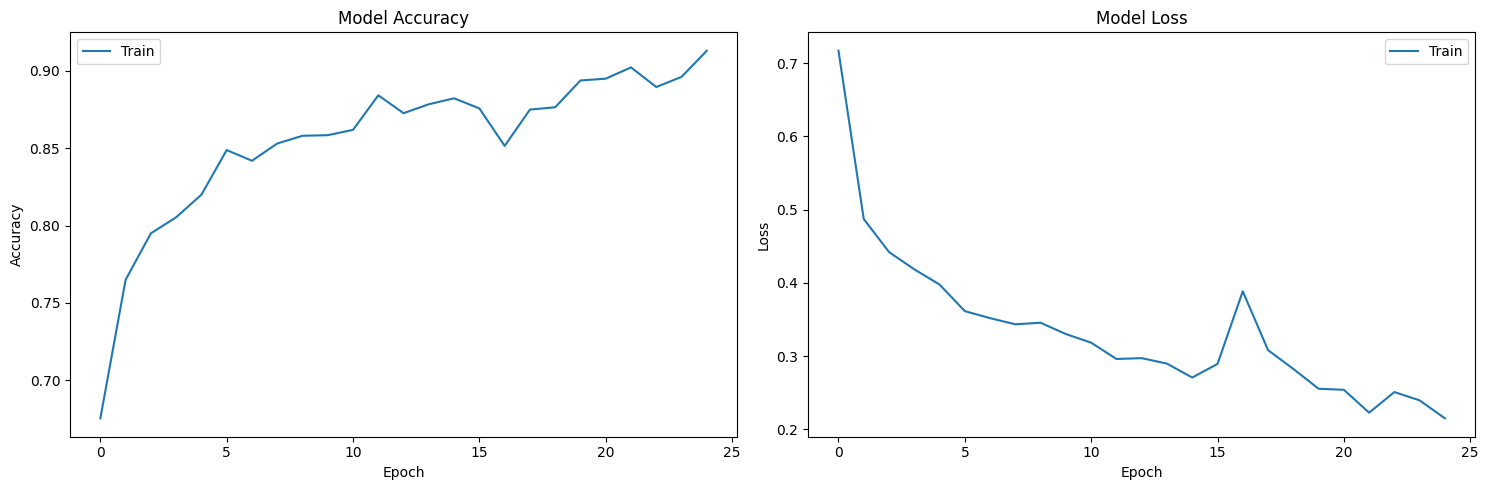

In [47]:
# Plotting training loss and accuracy
plt.figure(figsize=(15,5))

# Plot training accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')

# Plot training loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')

plt.tight_layout()
plt.show()


### Saving the Model

Here, the trained model is saved to a file named "pneumonia_classifier.h5" in the "/content/" directory.

The `.h5` format is a convenient way to save Keras models. Once saved, the model can be loaded again using `tf.keras.models.load_model()` method, which allows for predictions on new data, further training, or model evaluation without the need to retrain the model from scratch.

This step is crucial especially when the training of models takes a considerable amount of time or resources. By saving the model, you are ensuring that you can reuse your trained model in different sessions or on different platforms without any retraining.

Remember: Always keep a backup of your trained models, especially if they take a long time to train or if you've achieved a particularly good performance.

In [44]:
model.save("/content/pneumonia_classifier.h5")


**If you want to load the model**

```
loaded_model = tf.keras.models.load_model("/content/pneumonia_classifier.h5")

```



### Distribution of Images in the Dataset

This code visualizes the distribution of images between the two classes, `Pneumonia` and `Normal`. It's a pie chart representation that gives an immediate understanding of the balance (or imbalance) between the classes in the dataset.

Understanding the distribution of classes is essential because:

1. **Imbalanced datasets** can lead to biases in the model where the model may simply predict the majority class for most inputs. This can lead to misleadingly high accuracy rates but poor performance in predicting the minority class.

2. **Balanced datasets** provide a more even training base for the model, but it's not always possible or realistic to have a perfectly balanced dataset. In such cases, techniques like oversampling, undersampling, or using synthetic data generation can be considered.

The `explode` parameter in the `plt.pie()` function is used to offset the 'Pneumonia' slice to emphasize it. The colors and other properties make the chart visually appealing and easier to interpret.

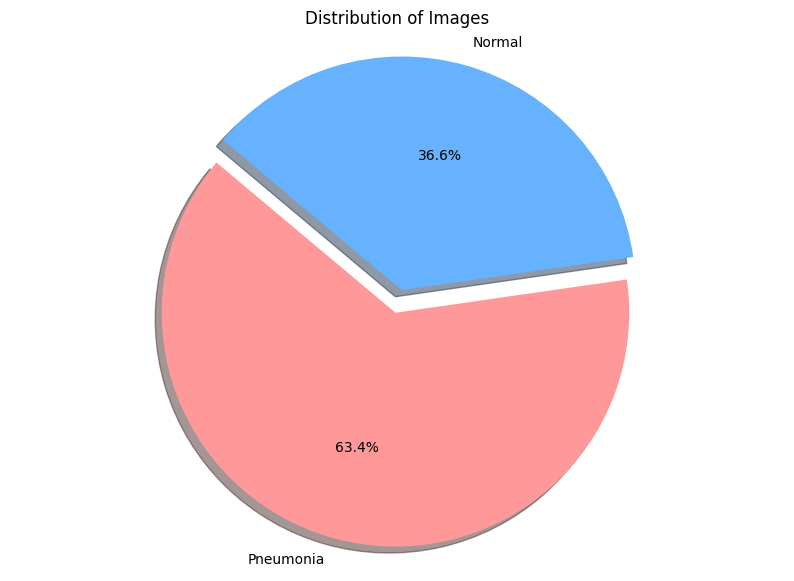

In [45]:
import os
import matplotlib.pyplot as plt

# Count the number of images in each category
num_pneumonia = len(os.listdir(os.path.join(main_dir, 'Pneumonia')))
num_normal = len(os.listdir(os.path.join(main_dir, 'Normal')))

# Plot
labels = ['Pneumonia', 'Normal']
sizes = [num_pneumonia, num_normal]
colors = ['#ff9999','#66b2ff']
explode = (0.1, 0)  # explode 1st slice for emphasis

plt.figure(figsize=(10,7))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.title('Distribution of Images')
plt.show()


### Displaying Random Sample Images from Each Category

This code is used to visualize random sample images from each category, namely `Pneumonia` and `Normal`. Visualizing the actual images can help in understanding:

1. **Image Quality:** By looking at the images, you can judge the quality and clarity of the images. Are they too blurry? Too dark or too bright? This can be crucial for medical images where clarity can make a significant difference in diagnosis.

2. **Variability:** You can understand the variability within the class. For instance, are all pneumonia images similar, or is there a broad range of manifestations of pneumonia in the X-rays?

3. **Anomalies:** By occasionally visualizing random samples, you might spot anomalies or outliers, such as images that don't belong to that category or are mislabeled.

In the function:
- `base_dir` is the root directory containing the categories.
- `category` is the type of image you want to display (`Pneumonia` or `Normal`).
- `num` is the number of random images you want to display from the category.

The function uses the Python Imaging Library (PIL) to open and display images. Random images from the specified category are displayed side by side for visual inspection. The images are displayed without axes for a clearer view, and the title indicates the category of the image.

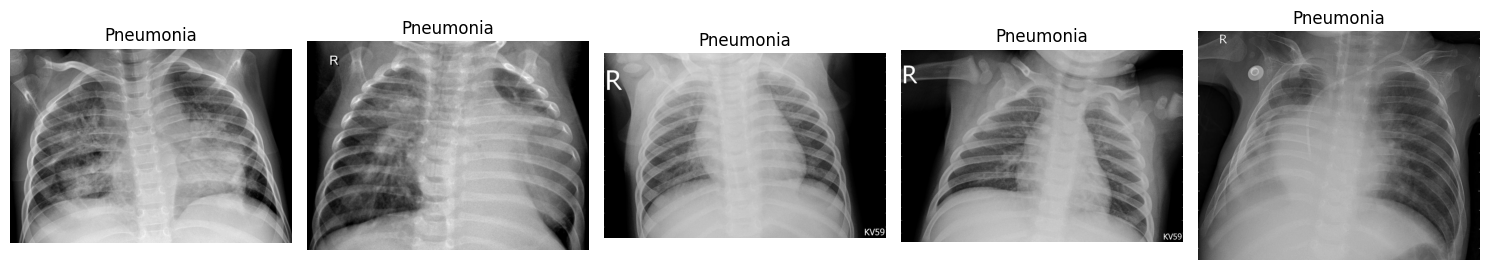

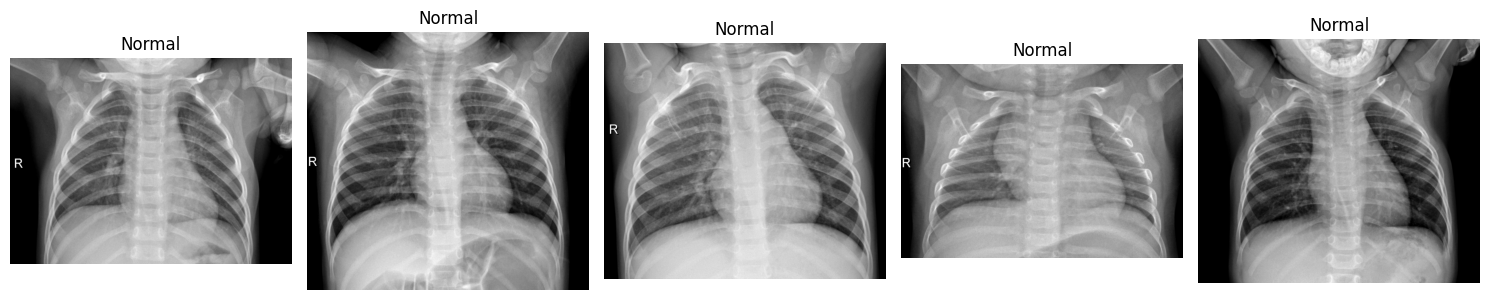

In [46]:
import random
from PIL import Image

def display_random_images(base_dir, category, num=5):
    path = os.path.join(base_dir, category)
    images = random.sample(os.listdir(path), num)

    plt.figure(figsize=(15,5))

    for i, img_name in enumerate(images):
        img_path = os.path.join(path, img_name)
        img = Image.open(img_path)

        plt.subplot(1, num, i+1)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
        plt.title(category)

    plt.tight_layout()
    plt.show()

# Display random images
display_random_images(main_dir, 'Pneumonia')
display_random_images(main_dir, 'Normal')


### Model Architecture Overview

By calling `model.summary()`, you will get a concise overview of all the layers in your model, along with details about the input and output shapes of each layer and the number of parameters (trainable and non-trainable).

Here's a brief description:

1. **Conv2D Layers**: These are convolutional layers that will learn the filters. The number next to Conv2D (like 32, 64, or 128) indicates the number of filters that the layer will learn. Each filter translates to learning a specific kind of feature from the image.

2. **MaxPooling2D Layers**: These layers are used to downsample the feature maps. It helps reduce the spatial dimensions, leading to a reduction in the number of parameters and computation. This is generally used to prevent overfitting and to ensure that the network has a broad view of the input image.

3. **Flatten Layer**: This layer is used to convert the 2D spatial data into a 1D vector. This is necessary as the final dense layers expect input in the form of 1D.

4. **Dense Layers**: These are your standard fully connected neural network layers. The model has one hidden dense layer with 512 neurons and a ReLU activation function.

5. **Dropout Layer**: Dropout is a regularization method where input and recurrent connections to the layer are probabilistically excluded from activation and weight updates while training a model. This helps prevent overfitting.

6. **Output Layer**: The final dense layer has 1 neuron with a sigmoid activation function, which is suitable for a binary classification task. If the output is close to 1, the model predicts the input image to be of the "Pneumonia" class, and if the output is close to 0, the prediction is the "Normal" class.

The summary also provides the number of trainable parameters in each layer. The total number of trainable parameters gives an idea of the model's capacity. The more parameters, the higher the capacity. However, if you have too many parameters relative to your number of samples, you might overfit. On the other hand, having too few parameters might lead to underfitting. Adjusting the model's capacity (by adding/removing layers or changing the number of neurons/filters) can be a part of the model tuning process.

In [48]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 26, 26, 128)     

### Visual Representation of Model Architecture

The given code segment leverages the TensorFlow's Keras utility function `plot_model` to create a visual representation of the model's architecture.

1. **plot_model function**: This function takes in the model instance and outputs a graphical representation of the architecture.
   
   - `to_file`: The file name to which the image should be saved.
   - `show_shapes`: Shows the shapes of the input and output tensors for each layer.
   - `show_layer_names`: Shows the names of the layers in the architecture.
   - `rankdir`: Determines whether the graph should be vertical (`'TB'`) or horizontal (`'LR'`).
   - `expand_nested`: If a model has nested models, setting this to `True` would show nested architectures in detail.
   - `dpi`: The resolution of the output image.

2. **IPython.display.Image**: This function displays an image file in Jupyter Notebooks and Google Colab.

After executing the provided code, you will see a visual representation of your neural network's architecture, depicting how the layers are interconnected, along with the shapes of the tensors flowing through the network. This visualization can be helpful for understanding the model's structure and for debugging or explaining the model to others.

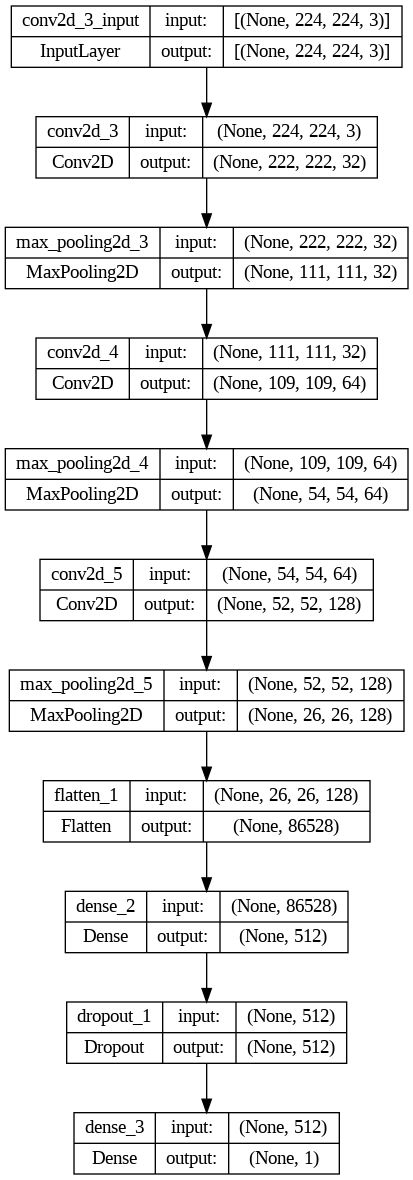

In [50]:
from tensorflow.keras.utils import plot_model
import IPython.display as display

# Plot the model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

# Display the image in the notebook
display.Image(filename='model_plot.png')


### Upload and Display an Image

The provided code facilitates the process of uploading an image to a Google Colab environment and displaying it.

1. **google.colab files.upload**: This function provides an interface to manually upload files from your local system to the Google Colab environment.

2. **PIL Image**: The Python Imaging Library (PIL) `Image` module provides functionalities for image manipulation. In this case, it's being used to open and handle the uploaded image file.

3. **plt.imshow**: Using the Matplotlib library, this function is employed to display the image in the notebook.

Upon executing the provided code, you will be prompted to select and upload an image from your local system. Once uploaded, the image will be displayed in the notebook. This is useful for visualizing and inspecting the content of the image before processing or making predictions on it.

Saving person8_virus_27.jpeg to person8_virus_27 (1).jpeg


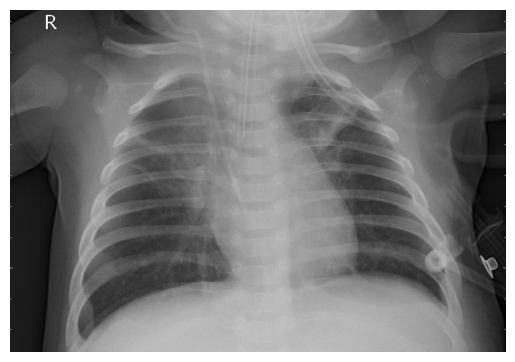

In [68]:
from google.colab import files
from PIL import Image
import numpy as np

uploaded = files.upload()

# Take the first uploaded file (in case you've uploaded multiple files)
image_name = list(uploaded.keys())[0]

# Load and display the image
image = Image.open(image_name)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()


### Preprocessing the Uploaded Image

This code resizes and preprocesses the uploaded image to prepare it for model prediction. Here's what each step does:

1. **Resize the image**: It's essential to ensure that the input image matches the input shape the neural network model expects. Most deep learning models require fixed-size inputs, hence the need to resize.

2. **Normalization**: Image pixel values are usually between 0 to 255. Dividing each pixel value by 255 scales the pixel values between 0 and 1. This normalization helps in improving the model's performance.

3. **Check for channels dimension**: Images can be in grayscale (having just one channel), RGB (three channels), or sometimes RGBA (four channels - with transparency). This step ensures that grayscale images have an explicit channel dimension.

4. **Add a batch dimension**: Neural networks typically process images in batches. Even if you have only one image, the model expects it in batch format. The code adds an extra dimension to simulate a batch.

After these steps, the image is ready to be passed through the neural network for prediction.

In [69]:
# Resize the image to the expected input shape
image = image.resize((224, 224))

# Convert to numpy array and normalize
image_array = np.array(image) / 255.0

# Check the shape of the image_array. If it's missing the channels dimension, reshape it
if len(image_array.shape) == 2:
    image_array = np.expand_dims(image_array, axis=-1)  # Add the channels dimension

# Add a batch dimension
image_array = np.expand_dims(image_array, axis=0)


### Converting Grayscale Image to RGB

In some instances, the model you trained might expect 3-channel RGB images. If you input a grayscale image (which has only 1 channel) directly, it would raise an error.

This code checks if the uploaded image is grayscale (mode 'L' in the PIL library stands for luminance, which represents grayscale). If the image is grayscale, it gets converted to an RGB image. The conversion doesn't add color to the image but replicates the grayscale channel across the three RGB channels, making the image compatible with models expecting 3-channel input.

This step ensures that regardless of the uploaded image's mode, the image passed to the model will always be in RGB format.

In [70]:
# Convert grayscale to RGB
if image.mode == 'L':
    image = image.convert('RGB')


### Preprocessing the Image for Model Prediction

This section of the code takes care of the final preprocessing steps before the image is input into the model for prediction.

1. **Resizing the Image**: The image is resized to the size `(224, 224)` which matches the input shape expected by the model.

2. **Normalizing the Image**: Models trained with TensorFlow/Keras often expect input values to be in the range `[0, 1]` for best performance. By dividing the image's pixel values by `255.0` (the maximum value for an 8-bit color channel), we ensure the values are in this range.

3. **Adding a Batch Dimension**: Deep learning models expect input in batches. Even if you're predicting for just one image, it needs to be treated as a batch of size 1. The `np.expand_dims` function is used to add an additional dimension to the beginning of the numpy array, simulating a batch of size 1.

In [71]:
# Resize the image
image = image.resize((224, 224))

# Convert to numpy array and normalize
image_array = np.array(image) / 255.0

# Add a batch dimension
image_array = np.expand_dims(image_array, axis=0)


### Predicting with the Model

In this section:

1. **Predicting using the Model**: The `model.predict()` method is used to get the model's predicted probabilities for the given input.

2. **Interpreting the Prediction**: For binary classification problems where the output is a sigmoid function, the predicted value will be in the range `[0, 1]`. A common approach is to use a threshold value of `0.5` to classify the predictions. If the predicted probability is greater than or equal to `0.5`, the model predicts the positive class (in this case, 'Pneumonia'). Otherwise, it predicts the negative class (in this case, 'Normal').

In [72]:
predictions = model.predict(image_array)

# If you have a binary classification, take the decision threshold as 0.5
predicted_class = 'Pneumonia' if predictions[0] >= 0.5 else 'Normal'
print(f"Model's Prediction: {predicted_class}")


1/1 [==============================] - 0s 73ms/step
Model's Prediction: Pneumonia


### Visualizing Training Metrics

In this section:

1. **Setting up the Visualization**: A larger figure size is set up to ensure that both the plots are clearly visible.

2. **Plotting Training Loss**: The training loss values saved in the `history` object are plotted. This plot provides insights into how well the model's predictions are aligning with the actual values (labels) during the training phase.

3. **Plotting Training Accuracy**: Similarly, the training accuracy values from the `history` object are plotted. This provides a view of the proportion of correct predictions made by the model in each epoch during training.

The plots help in understanding how the model performance evolves over epochs. If the training loss is decreasing and the accuracy is increasing, it's usually a good sign. If the metrics plateau or worsen, it might indicate issues like overfitting.

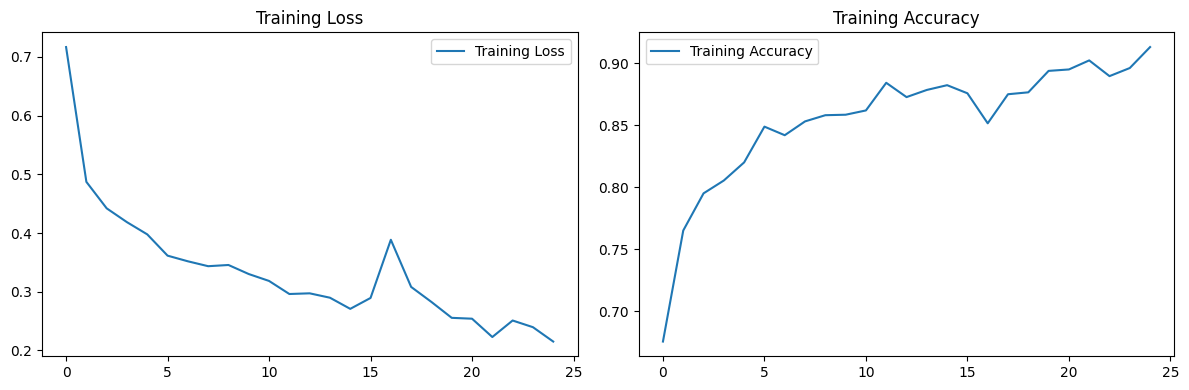

In [75]:
import matplotlib.pyplot as plt

# Plot Training Loss & Accuracy
plt.figure(figsize=(12, 4))

# Plot Training Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.legend()
plt.title('Training Loss')

# Plot Training Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.legend()
plt.title('Training Accuracy')

plt.tight_layout()
plt.show()


### Preparing Training and Testing Datasets

In this section:

1. **Directory Definitions**: Initial paths for the source directory (`src_dir`) and main directory (`main_dir`) are defined. The subdirectories for training and testing datasets (`train_dir` and `test_dir`) are created within the `main_dir`.

2. **Creating Necessary Directories**: For each category (Normal and Pneumonia), respective subdirectories are created within both `train_dir` and `test_dir`.

3. **Function to Split Data (`split_data`)**: This function accepts source, training, and testing directories, and a split size as arguments. It then:
    * Shuffles the list of image files in the source directory.
    * Calculates the number of files to be moved to the test directory based on the provided `split_size`.
    * Moves the calculated number of images to the test directory.
    * Moves the remaining images to the training directory.

4. **Splitting Data**: The `split_data` function is then invoked for both the `Normal` and `Pneumonia` categories to divide the dataset into training and testing sets based on the specified `split_size` (in this case, 20% of the images are used for testing).

By executing this section, the dataset will be prepared with a clear demarcation between training and testing images for each category. This ensures that the model can be trained on one subset and evaluated on a completely separate subset, allowing for a more objective assessment of its performance.

In [78]:
import os
import shutil
import random

# Define the main directories
src_dir = '/content/train_data'
main_dir = '/content/data'
train_dir = os.path.join(main_dir, 'train')
test_dir = os.path.join(main_dir, 'test')

# Create the necessary directories
for dir_path in [train_dir, test_dir]:
    for category in ['Normal', 'Pneumonia']:
        new_path = os.path.join(dir_path, category)
        if not os.path.exists(new_path):
            os.makedirs(new_path)

# Function to split data
def split_data(source_dir, train_dir, test_dir, split_size):
    files = os.listdir(source_dir)
    random.shuffle(files)

    num_to_move = int(len(files) * split_size)
    for file in files[:num_to_move]:
        shutil.move(os.path.join(source_dir, file), os.path.join(test_dir, file))
    for file in files[num_to_move:]:
        shutil.move(os.path.join(source_dir, file), os.path.join(train_dir, file))

# Split the normal and pneumonia images
split_size = 0.2
split_data(os.path.join(src_dir, 'Normal'), os.path.join(train_dir, 'Normal'), os.path.join(test_dir, 'Normal'), split_size)
split_data(os.path.join(src_dir, 'Pneumonia'), os.path.join(train_dir, 'Pneumonia'), os.path.join(test_dir, 'Pneumonia'), split_size)


### Model Evaluation on Test Set

In this section:

1. **ImageDataGenerator for Test Set**: We initialize an `ImageDataGenerator` instance for the test dataset. Unlike the training dataset, we don't need data augmentation for testing. The only preprocessing step we apply is the rescaling of the image values (`rescale=1./255`), which ensures that pixel values are in the range [0, 1]. This matches the normalization applied during training.

2. **Loading Test Images**: Using the `flow_from_directory` method, the test images are loaded from the specified directory (`test_dir`). Images are resized to 224x224 pixels, which is the expected input size for the model. The batch size is set to 32, and the class mode is 'binary' (as we have two classes: Normal and Pneumonia). We set `shuffle=False` to ensure the images are processed in the order they appear in the directory, which is useful when we later want to create confusion matrices or analyze results.

3. **Model Evaluation**: The model's performance is evaluated on the test dataset using the `evaluate` method, which returns the loss and accuracy.

By executing this section, you'll get a clear understanding of how well your model performs on unseen data. The reported loss and accuracy provide insights into the model's generalization capabilities. The closer the test accuracy is to the training accuracy (without being overly high), the better the model generalizes. If there's a significant gap between training and test performance, this might be an indication of overfitting during training.

In [79]:
import tensorflow as tf

# Initialize ImageDataGenerator for the test set without data augmentation
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Load test images from the directory
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),  # assuming your model accepts 224x224 images
    batch_size=32,
    class_mode='binary',
    shuffle=False  # ensure the order remains the same
)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_generator, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Found 519 images belonging to 2 classes.
17/17 [==============================] - 25s 1s/step - loss: 0.2088 - accuracy: 0.9191
Test Loss: 0.2088
Test Accuracy: 0.9191


### Generating Predictions for Test Set

In this section:

1. **Obtaining Predictions**: We use the `predict` method of our model to get predictions for each image in the test dataset. This method returns continuous values in the range [0, 1] due to the sigmoid activation in the final layer of our model.

2. **Converting Predictions to Binary Labels**: As we are dealing with binary classification (Normal and Pneumonia), we set a threshold at 0.5 to convert the continuous predictions into binary class labels. If a prediction value is greater than or equal to 0.5, it is classified as Pneumonia (`1`), otherwise as Normal (`0`).

This binary classification allows for a straightforward interpretation of the model's predictions. With the obtained predicted labels and the true labels from the test dataset, further analyses like confusion matrices, precision, recall, and F1 score can be computed to provide a comprehensive understanding of the model's performance.

In [80]:
# Get predictions for the test set
predictions = model.predict(test_generator)
# Convert predictions to binary labels
predicted_labels = np.where(predictions >= 0.5, 1, 0)

17/17 [==============================] - 26s 1s/step


### Extracting Actual Labels from Test Set

In this section, we are obtaining the true labels of the test dataset.

The `ImageDataGenerator`'s `flow_from_directory` method assigns an index (integer) to each class it finds in the directory, sorted in alphabetical order. Since our classes are 'Normal' and 'Pneumonia', and 'Normal' comes before 'Pneumonia' alphabetically, 'Normal' will be given the index `0` and 'Pneumonia' will be given the index `1`.

By accessing the `.classes` attribute of the `test_generator` object, we get an array of these integer labels for each image in the order they are found in the directory. This allows us to compare our model's predictions (`predicted_labels`) to the actual labels (`actual_labels`) to determine how well our model performed on the test dataset.

In [81]:
actual_labels = test_generator.classes


### Visualizing Model Performance with a Confusion Matrix

In this section, we use the `confusion_matrix` function from the `scikit-learn` library to compute the confusion matrix based on the actual and predicted labels of the test dataset.

The confusion matrix provides a way to visualize the performance of a classification model. The rows of the matrix represent the actual classes, while the columns represent the predicted classes.

For a binary classification task like this:
- **True Positive (TP)**: Number of Pneumonia images correctly classified as Pneumonia.
- **True Negative (TN)**: Number of Normal images correctly classified as Normal.
- **False Positive (FP)**: Number of Normal images wrongly classified as Pneumonia.
- **False Negative (FN)**: Number of Pneumonia images wrongly classified as Normal.

The matrix is visualized using the `heatmap` function from the `seaborn` library. This heatmap allows us to easily see how many samples were correctly or incorrectly classified by our model, and can help inform potential areas for model improvement.

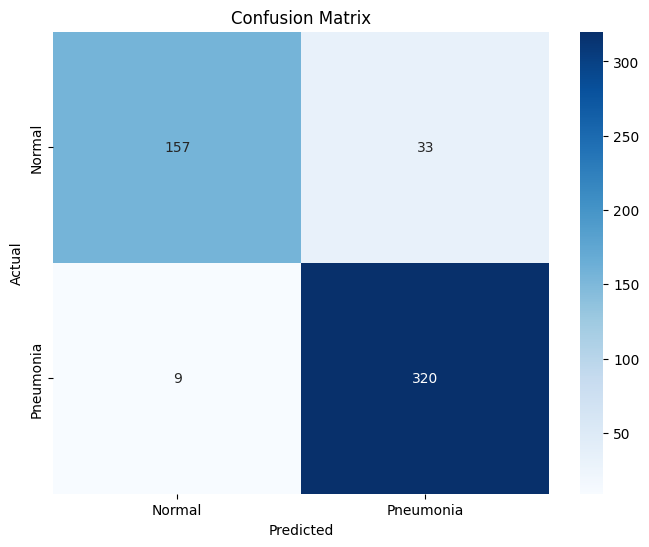

In [82]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
